<a href="https://colab.research.google.com/github/Misha-private/Demo-repo/blob/main/C_grid_ShallEqsModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# C-grid shallow water model on beta plane


Starting integration...
dx=78125.0 m, dy=62500.0 m, dt=300.0 s, nx=256, ny=96
Initial mass=1.200000e+17, energy=5.457513e+15
[     1] Mass drift=+9.878e-11, Energy rel=+7.887e-05


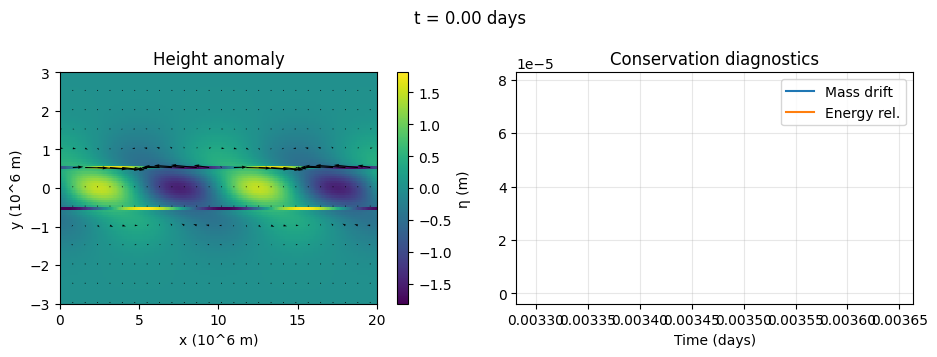

[   150] Mass drift=+1.634e-06, Energy rel=+4.517e-02


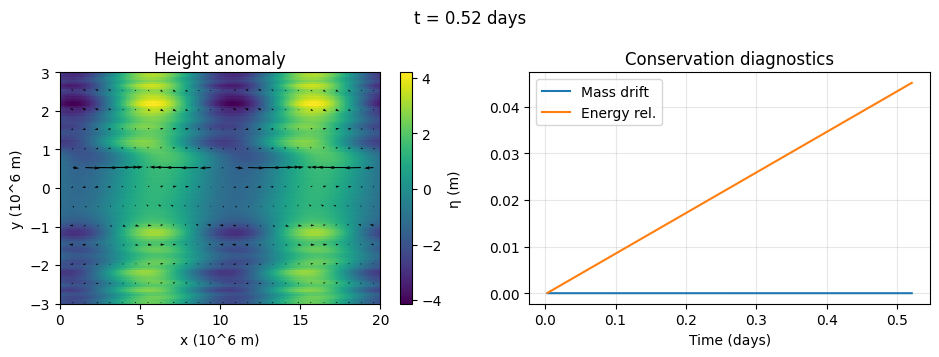

[   300] Mass drift=+2.768e-06, Energy rel=+1.155e-01


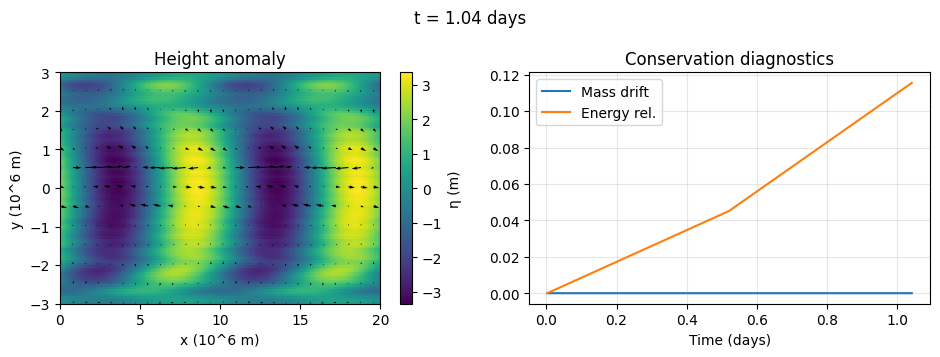

[   450] Mass drift=+2.211e-06, Energy rel=+2.804e-01


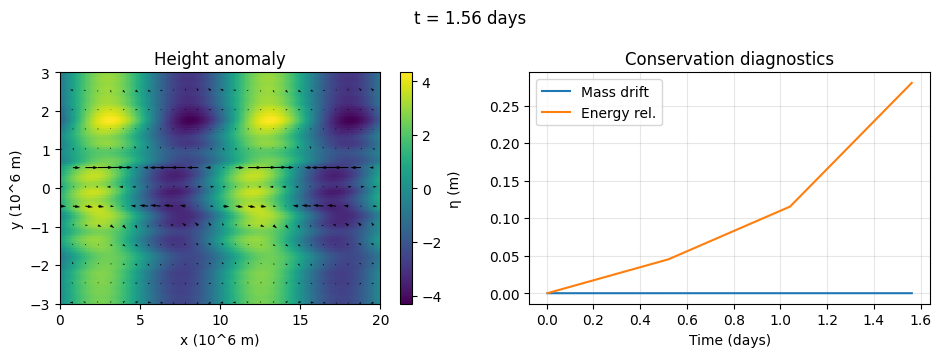

[   600] Mass drift=+1.130e-05, Energy rel=+1.031e+00


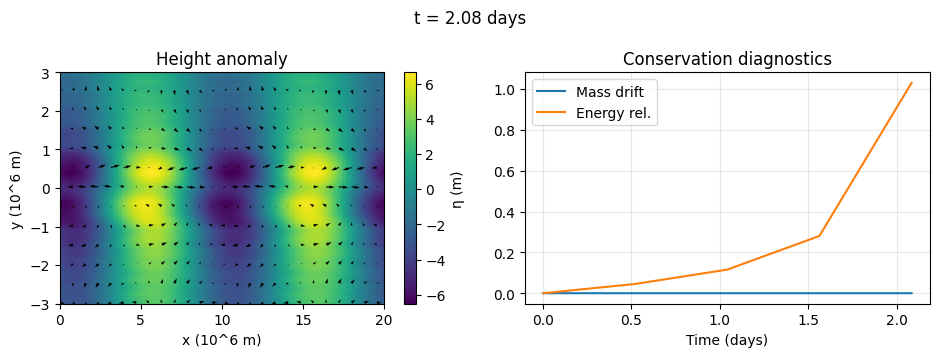

[   750] Mass drift=+4.767e-06, Energy rel=+1.489e+00


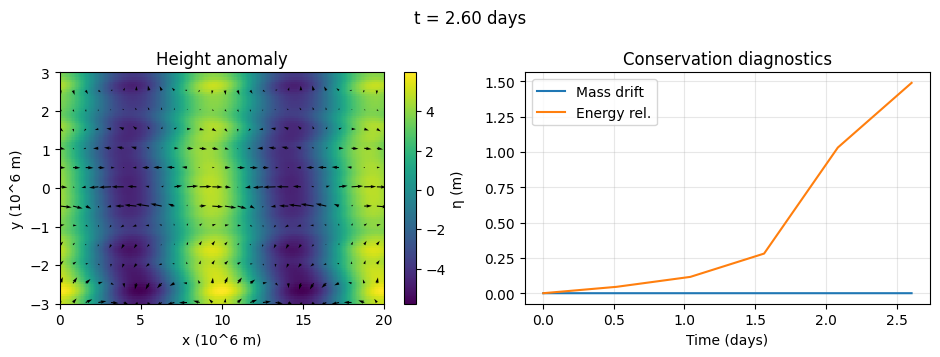

[   900] Mass drift=+1.504e-05, Energy rel=+3.839e+00


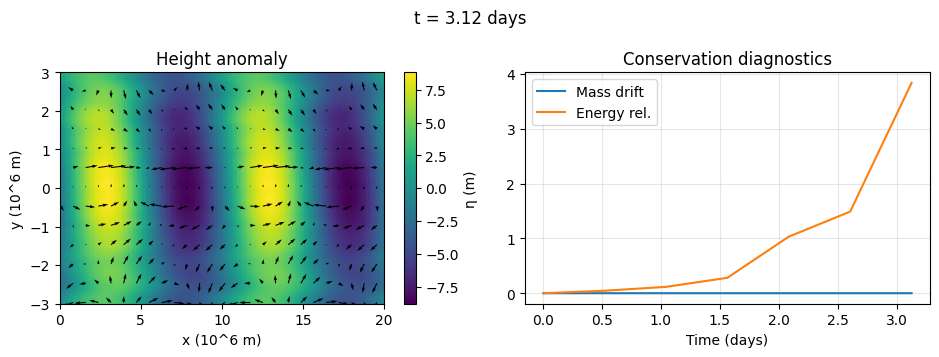

[  1050] Mass drift=+2.321e-05, Energy rel=+5.803e+00


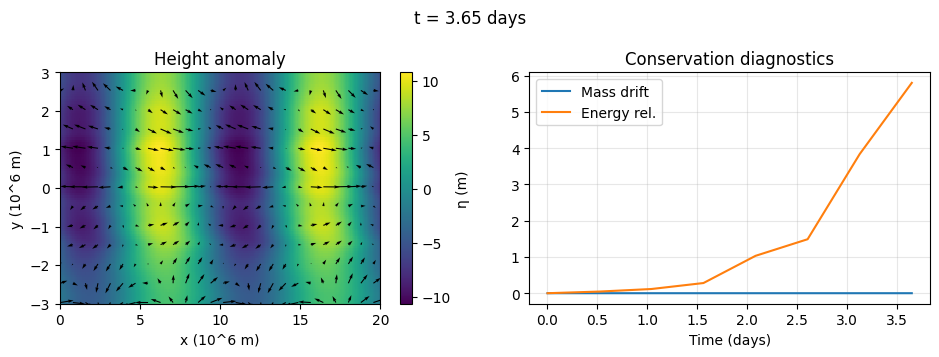

[  1200] Mass drift=+2.704e-05, Energy rel=+1.197e+01


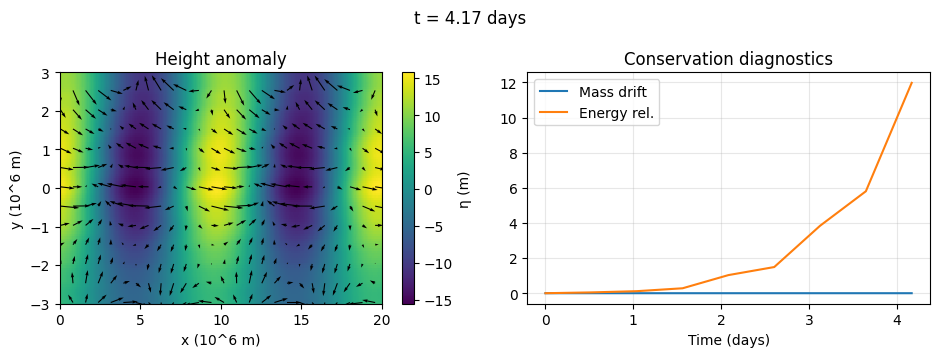

[  1350] Mass drift=+6.754e-05, Energy rel=+2.013e+01


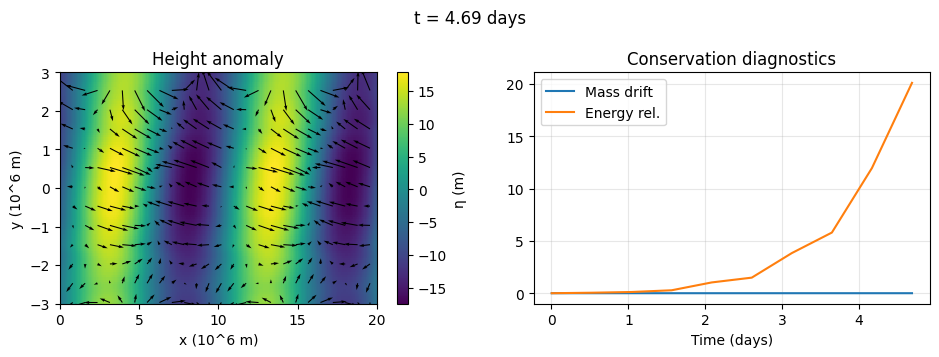

[  1500] Mass drift=+1.204e-04, Energy rel=+3.949e+01


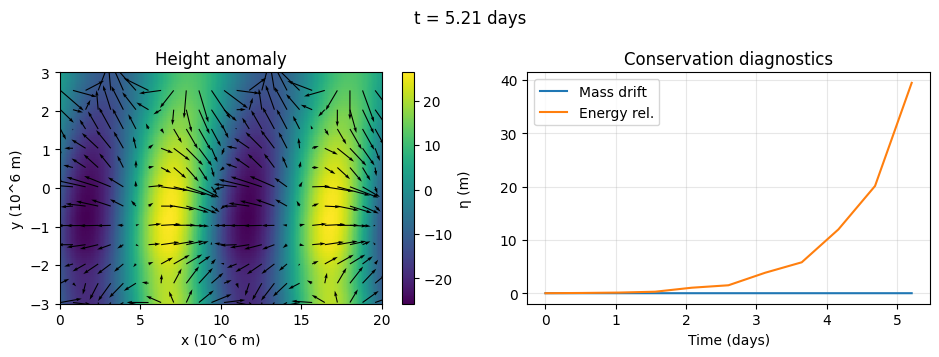

Done.


In [11]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Full nonlinear shallow-water model on an Arakawa C-grid, beta-plane.
- Vector-invariant (Sadourny-style) momentum discretization
- Periodic BCs in x (via wrap padding in operators)
- Mirror/reflective BCs in y (v=0; ∂u/∂y=∂h/∂y=0)
- RK4 time stepping
- Laplacian diffusion on u, v, h
- Mixed (Kelvin + Rossby-like) initial height perturbation; geostrophic winds
"""

import numpy as np
import matplotlib.pyplot as plt

# ---------------------------
# Physical & model params
# ---------------------------
g     = 9.81
H     = 1000.0
beta  = 2.0e-11
f0    = 0.0
f_min = 1.0e-5   # floor for geostrophic init near equator

# Domain/grid
Lx, Ly = 2.0e7, 6.0e6
nx, ny = 256, 96
dx, dy = Lx/nx, Ly/ny

# Time stepping
dt   = 300.0
nt   = 1500
nout = 150

# Diffusion (Laplacian)
nu_u, nu_v, nu_h = 2.0e4, 2.0e4, 1.0e4

# Initial height perturbation (Kelvin + Rossby-like)
A_k, A_r = 1.5, 1.0
Lk, Lr   = 5.0e5, 1.0e6
nwave    = 2

# ---------------------------
# Grids
# ---------------------------
x_c = np.linspace(0.5*dx, Lx - 0.5*dx, nx)
y_c = np.linspace(0.5*dy, Ly - 0.5*dy, ny)
Xc, Yc = np.meshgrid(x_c, y_c)            # centers: (ny, nx)

x_u = np.linspace(0.0, Lx, nx+1)          # u at x-faces: (ny, nx+1)
y_v = np.linspace(0.0, Ly, ny+1)          # v at y-faces: (ny+1, nx)
Xu, Yu = np.meshgrid(x_u, y_c)            # (ny, nx+1)
Xv, Yv = np.meshgrid(x_c, y_v)            # (ny+1, nx)

def f_on_y(y): return f0 + beta*(y - 0.5*Ly)
f_c = f_on_y(Yc)                           # (ny, nx)
f_u = f_on_y(Yu)                           # (ny, nx+1)
f_v = f_on_y(Yv)                           # (ny+1, nx)

# ---------------------------
# Boundary conditions
# ---------------------------
def apply_bc(u, v, h):
    # Mirror in y for u,h; impermeable for v
    u[0, :],  u[-1, :]  = u[1, :],  u[-2, :]
    h[0, :],  h[-1, :]  = h[1, :],  h[-2, :]
    v[0, :],  v[-1, :]  = 0.0, 0.0
    return u, v, h

# ---------------------------
# Diffusion (Laplacian) on native grids
# ---------------------------

def _d2x_periodic(phi):
    # second derivative in x with periodic BCs (shape preserved)
    return (np.roll(phi, -1, axis=1) - 2.0*phi + np.roll(phi, 1, axis=1)) / (dx*dx)

def _d2y_neumann(phi):
    # second derivative in y with mirror/Neumann BCs (shape preserved)
    up = np.empty_like(phi)
    dn = np.empty_like(phi)
    # interior neighbors
    up[1:-1, :] = phi[2:, :]
    dn[1:-1, :] = phi[:-2, :]
    # mirror at top/bottom
    up[0, :]    = phi[1, :]     # "ghost" equals first interior
    dn[0, :]    = phi[1, :]
    up[-1, :]   = phi[-2, :]
    dn[-1, :]   = phi[-2, :]
    return (up - 2.0*phi + dn) / (dy*dy)

def laplacian_center_xy(phi):
    # phi is on centers: (ny, nx)
    return _d2x_periodic(phi) + _d2y_neumann(phi)

def laplacian_u(phi):
    # phi is on u-grid: (ny, nx+1)
    return _d2x_periodic(phi) + _d2y_neumann(phi)

def laplacian_v(phi):
    # phi is on v-grid: (ny+1, nx)
    return _d2x_periodic(phi) + _d2y_neumann(phi)

# ---------------------------
# C-grid interpolation helpers
# ---------------------------
def avg_x(a):  # centers -> x-faces: (ny,nx) -> (ny,nx+1)
    return 0.5*(np.pad(a, ((0,0),(1,0)), mode='wrap') + np.pad(a, ((0,0),(0,1)), mode='wrap'))

def avg_y(a):  # centers -> y-faces: (ny,nx) -> (ny+1,nx)
    return 0.5*(np.pad(a, ((1,0),(0,0)), mode='edge') + np.pad(a, ((0,1),(0,0)), mode='edge'))

def center_from_u(a_u):  # (ny,nx+1) -> (ny,nx)
    return 0.5*(a_u[:, :-1] + a_u[:, 1:])

def center_from_v(a_v):  # (ny+1,nx) -> (ny,nx)
    return 0.5*(a_v[:-1, :] + a_v[1:, :])

# ---------------------------
# Derivatives (stagger-aware)
# ---------------------------
def ddx_center_to_u(phi_c):  # (ny,nx)->(ny,nx+1)
    phiL = np.pad(phi_c, ((0,0),(1,0)), mode='wrap')
    phiR = np.pad(phi_c, ((0,0),(0,1)), mode='wrap')
    return (phiR - phiL)/(2.0*dx)

def ddy_center_to_v(phi_c):
    """∂phi/∂y evaluated on v-faces (shape: ny+1, nx) from center values (ny, nx).
    Mirror (Neumann) at the north/south walls ⇒ derivative = 0 at j=0 and j=ny.
    Uses a stagger-aware first difference between adjacent center rows.
    """
    ny_, nx_ = phi_c.shape
    out = np.empty((ny_ + 1, nx_), dtype=phi_c.dtype)

    # interior v-faces (between center rows j-1 and j)
    out[1:-1, :] = (phi_c[1:, :] - phi_c[:-1, :]) / dy

    # walls: Neumann (∂/∂y = 0)
    out[0, :]  = 0.0
    out[-1, :] = 0.0
    return out


def ddx_u_to_center(phi_u):  # (ny,nx+1)->(ny,nx)
    return (phi_u[:, 1:] - phi_u[:, :-1])/dx

def ddy_v_to_center(phi_v):  # (ny+1,nx)->(ny,nx)
    return (phi_v[1:, :] - phi_v[:-1, :])/dy

# Centered diffs that keep (ny,nx) shape
def ddx_center_same(phi):  # periodic x
    phi_w = np.pad(phi, ((0,0),(1,1)), mode='wrap')
    return (phi_w[:, 2:] - phi_w[:, :-2])/(2.0*dx)

def ddy_center_same(phi):  # mirror y
    phi_y = np.pad(phi, ((1,1),(0,0)), mode='edge')
    return (phi_y[2:, :] - phi_y[:-2, :])/(2.0*dy)

# ---------------------------
# Vorticity on centers → to u/v
# ---------------------------
def compute_vorticity_centers(u, v):
    """
    ζ_c at cell centers using centered differences:
    ζ_c = ∂v_c/∂x - ∂u_c/∂y
    """
    uc = center_from_u(u)             # (ny, nx)
    vc = center_from_v(v)             # (ny, nx)
    return ddx_center_same(vc) - ddy_center_same(uc)


# ---------------------------
# RHS (Sadourny vector-invariant)
# ---------------------------
def rhs(u, v, h):
    u, v, h = apply_bc(u, v, h)

    # Absolute vorticity at u/v points via center ζ
    zeta_c = compute_vorticity_centers(u, v)   # (ny, nx)
    eta_u  = avg_x(zeta_c) + f_u               # (ny, nx+1)
    eta_v  = avg_y(zeta_c) + f_v               # (ny+1, nx)

    # Pressure gradients at native u/v points
    dhdx_u = ddx_center_to_u(h)                # (ny, nx+1)
    dhdy_v = ddy_center_to_v(h)                # (ny+1, nx)

    # Cross-velocity averages (Sadourny)
    v_above   = 0.5*(v[:-1, :] + v[1:, :])     # centers (ny, nx)
    v_tilde_u = avg_x(v_above)                 # (ny, nx+1)

    u_left    = 0.5*(u[:, :-1] + u[:, 1:])     # centers (ny, nx)
    u_tilde_v = avg_y(u_left)                  # (ny+1, nx)

    # Mass fluxes and divergence
    h_u = avg_x(h)                             # (ny, nx+1)
    h_v = avg_y(h)                             # (ny+1, nx)
    dFdx = ddx_u_to_center(h_u * u)            # (ny, nx)
    dFdy = ddy_v_to_center(h_v * v)            # (ny, nx)

    du   = -g * dhdx_u + eta_u * v_tilde_u + nu_u * laplacian_u(u)
    dv   = -g * dhdy_v - eta_v * u_tilde_v + nu_v * laplacian_v(v)
    dhdt = -(dFdx + dFdy) + nu_h * laplacian_center_xy(h)

    # keep tendencies tidy near boundaries
    du, dv, dhdt = apply_bc(du, dv, dhdt)
    return du, dv, dhdt

# ---------------------------
# RK4 integrator
# ---------------------------
def rk4_step(u, v, h, dt):
    k1_u, k1_v, k1_h = rhs(u, v, h)

    u2, v2, h2 = apply_bc(u + 0.5*dt*k1_u, v + 0.5*dt*k1_v, h + 0.5*dt*k1_h)
    k2_u, k2_v, k2_h = rhs(u2, v2, h2)

    u3, v3, h3 = apply_bc(u + 0.5*dt*k2_u, v + 0.5*dt*k2_v, h + 0.5*dt*k2_h)
    k3_u, k3_v, k3_h = rhs(u3, v3, h3)

    u4, v4, h4 = apply_bc(u + dt*k3_u, v + dt*k3_v, h + dt*k3_h)
    k4_u, k4_v, k4_h = rhs(u4, v4, h4)

    u_new = u + (dt/6.0)*(k1_u + 2*k2_u + 2*k3_u + k4_u)
    v_new = v + (dt/6.0)*(k1_v + 2*k2_v + 2*k3_v + k4_v)
    h_new = h + (dt/6.0)*(k1_h + 2*k2_h + 2*k3_h + k4_h)
    return apply_bc(u_new, v_new, h_new)

# ---------------------------
# Initialization
# ---------------------------
def initialize_fields():
    # Mixed Kelvin + Rossby height perturbation at centers
    kx = 2.0*np.pi*nwave / Lx
    eta_kelvin = A_k * np.exp(-(Yc - 0.5*Ly)**2 / (Lk**2)) * np.sin(kx*Xc)
    eta_rossby = A_r * ((Yc - 0.5*Ly)/Lr) * np.exp(-(Yc - 0.5*Ly)**2 / (Lr**2)) * np.cos(kx*Xc)
    h = H + eta_kelvin + eta_rossby                      # (ny, nx)

    # Centered gradients that keep (ny,nx), then map to u/v grids
    dhdx_c = ddx_center_same(h)                          # (ny, nx)
    dhdy_c = ddy_center_same(h)                          # (ny, nx)
    dhdx_v = avg_y(dhdx_c)                               # (ny+1, nx)
    dhdy_u = avg_x(dhdy_c)                               # (ny,   nx+1)

    # Regularize f near equator
    f_reg_u = np.where(np.abs(f_u) < f_min, f_min*np.sign(f_u + 1e-12), f_u)
    f_reg_v = np.where(np.abs(f_v) < f_min, f_min*np.sign(f_v + 1e-12), f_v)

    # Geostrophic winds
    u_g = -(g / f_reg_u) * dhdy_u                        # (ny, nx+1)
    v_g =  (g / f_reg_v) * dhdx_v                        # (ny+1, nx)

    # Kelvin-like fallback right at equator
    mask_u = np.abs(f_u) < f_min
    mask_v = np.abs(f_v) < f_min
    u_g = np.where(mask_u, -np.sqrt(g/H) * dhdy_u, u_g)
    v_g = np.where(mask_v,  0.0, v_g)

    return apply_bc(u_g.copy(), v_g.copy(), h.copy())

# ---------------------------
# Diagnostics
# ---------------------------
def total_mass(h): return np.sum(h) * dx * dy

def total_energy(u, v, h):
    uc = center_from_u(u)
    vc = center_from_v(v)
    ke = 0.5 * h * (uc**2 + vc**2)
    pe = 0.5 * g * (h - H)**2
    return np.sum(ke + pe) * dx * dy

# ---------------------------
# Main
# ---------------------------
def main():
    u, v, h = initialize_fields()
    M0, E0 = total_mass(h), total_energy(u, v, h)

    print("Starting integration...")
    print(f"dx={dx:.1f} m, dy={dy:.1f} m, dt={dt:.1f} s, nx={nx}, ny={ny}")
    print(f"Initial mass={M0:.6e}, energy={E0:.6e}")

    mass_hist, ener_hist, time_hist = [], [], []

    for n in range(1, nt+1):
        u, v, h = rk4_step(u, v, h, dt)

        if (n % nout) == 0 or n == 1:
            tdays = n*dt/86400.0
            M, E = total_mass(h), total_energy(u, v, h)
            mass_hist.append(M); ener_hist.append(E); time_hist.append(tdays)
            print(f"[{n:6d}] Mass drift={(M-M0)/M0:+.3e}, Energy rel={(E-E0)/E0:+.3e}")

            # Quick-look plot
            plt.figure(figsize=(9.5, 3.6))
            plt.suptitle(f"t = {tdays:.2f} days")

            ax = plt.subplot(1, 2, 1)
            im = ax.pcolormesh(Xc/1e6, (Yc - 0.5*Ly)/1e6, h - H, shading='auto')
            plt.colorbar(im, ax=ax, label='η (m)')
            ax.set_title("Height anomaly")
            ax.set_xlabel("x (10^6 m)")
            ax.set_ylabel("y (10^6 m)")
            # quiver (downsample)
            skipx = slice(0, nx, max(1, nx//24))
            skipy = slice(0, ny, max(1, ny//12))
            uc = center_from_u(u)[skipy, skipx]
            vc = center_from_v(v)[skipy, skipx]
            ax.quiver(Xc[skipy, skipx]/1e6, (Yc[skipy, skipx]-0.5*Ly)/1e6, uc, vc, scale=2e1)

            ax2 = plt.subplot(1, 2, 2)
            # Always plot (even single point); then only add legend if something was drawn.
            handles = []
            if len(time_hist) >= 1:
                l1, = ax2.plot(time_hist, (np.array(mass_hist)-M0)/M0, label='Mass drift')
                handles.append(l1)
                l2, = ax2.plot(time_hist, (np.array(ener_hist)-E0)/E0, label='Energy rel.')
                handles.append(l2)

            ax2.set_xlabel("Time (days)")
            ax2.set_title("Conservation diagnostics")
            if handles:
                ax2.legend()   # only if we actually plotted something
            ax2.grid(True, alpha=0.3)

            plt.tight_layout()
            plt.pause(0.01)
            plt.show(block=False)




    print("Done.")

if __name__ == "__main__":
    main()


# GNN base ML shallo-water model

In [13]:
!pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 18.2 MB/s eta 0:00:00


Device: cpu
Generating FD trajectory...


/usr/local/lib/python3.12/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Dataset: 396 pairs | Train 316 / Val 80 | Nodes 6144
[001] train 4.3212e+05 | val 2.0303e+02
[002] train 2.6524e+02 | val 1.7793e+02
[003] train 1.8614e+02 | val 1.7721e+02
[004] train 1.8563e+02 | val 1.7675e+02
[005] train 1.8534e+02 | val 1.7646e+02
[006] train 1.8518e+02 | val 1.7627e+02
[007] train 1.8509e+02 | val 1.7616e+02
[008] train 1.8504e+02 | val 1.7608e+02
[009] train 1.8502e+02 | val 1.7602e+02
[010] train 1.8501e+02 | val 1.7599e+02
[011] train 1.8500e+02 | val 1.7595e+02
[012] train 1.8499e+02 | val 1.7593e+02
[013] train 1.8499e+02 | val 1.7592e+02
[014] train 1.8499e+02 | val 1.7591e+02
[015] train 1.8498e+02 | val 1.7589e+02
[016] train 1.8498e+02 | val 1.7588e+02
[017] train 1.8498e+02 | val 1.7588e+02
[018] train 1.8498e+02 | val 1.7588e+02
[019] train 1.8497e+02 | val 1.7587e+02
[020] train 1.8497e+02 | val 1.7587e+02
[021] train 1.8497e+02 | val 1.7586e+02
[022] train 1.8497e+02 | val 1.7586e+02
[023] train 1.8496e+02 | val 1.7587e+02
[024] train 1.8496e+02 | va

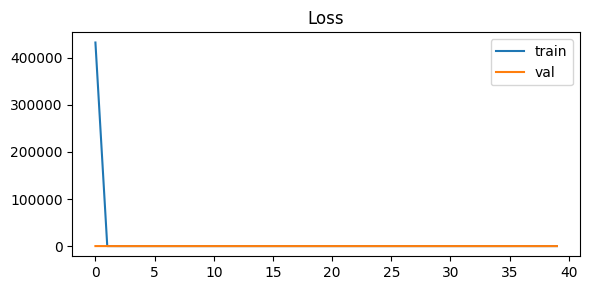

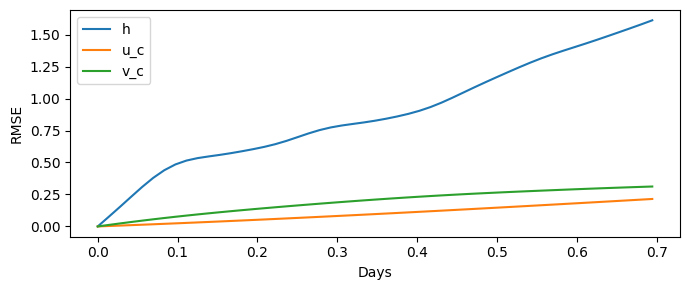

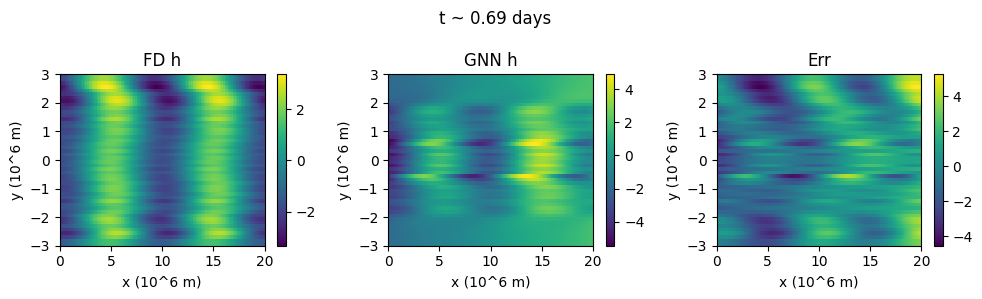

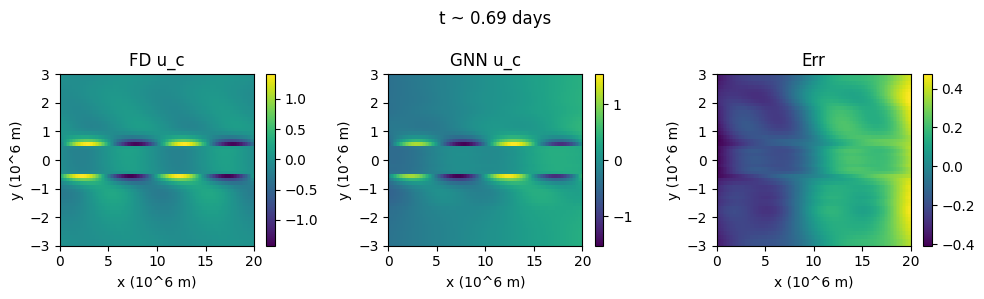

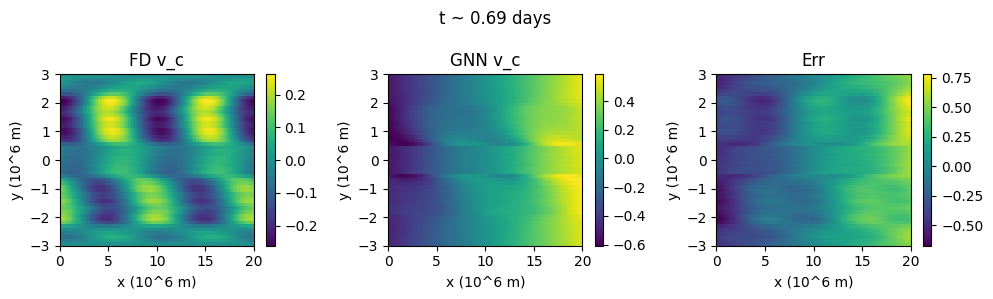

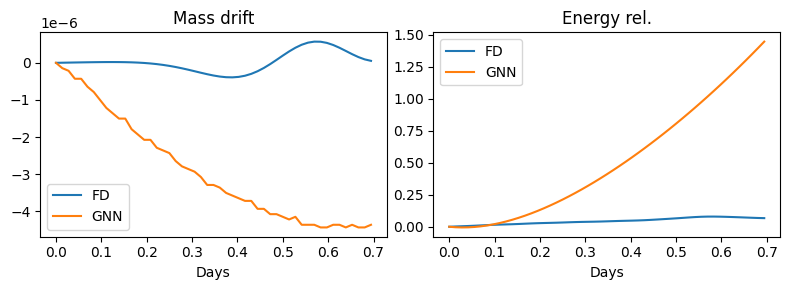

In [14]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
FD -> GNN pipeline for nonlinear SWE (beta-plane, C-grid):
- Generate data with the FD model you just ran (shortened, same numerics).
- Build a 4-neighbor graph over centers (periodic-x, mirror-y).
- Train a residual GraphSAGE to advance (h, u_c, v_c) by coarse ΔT.
- Evaluate via single-step metrics and multi-step rollout vs FD reference.

Author: you
"""

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.data import Data, Dataset, DataLoader
from torch_geometric.nn import SAGEConv, LayerNorm
import matplotlib.pyplot as plt
from typing import Tuple

# ---------------------------
# FD model (trimmed; same numerics as your working script)
# ---------------------------
g     = 9.81
H     = 1000.0
beta  = 2.0e-11
f0    = 0.0
f_min = 1.0e-5

Lx, Ly = 2.0e7, 6.0e6
nx, ny = 128, 48                 # use smaller grid for dataset speed; you can raise later
dx, dy = Lx/nx, Ly/ny

dt_fd = 300.0
nu_u, nu_v, nu_h = 2.0e4, 2.0e4, 1.0e4

A_k, A_r = 1.5, 1.0
Lk, Lr   = 5.0e5, 1.0e6
nwave    = 2

# grids
x_c = np.linspace(0.5*dx, Lx-0.5*dx, nx)
y_c = np.linspace(0.5*dy, Ly-0.5*dy, ny)
Xc, Yc = np.meshgrid(x_c, y_c)
x_u = np.linspace(0.0, Lx, nx+1)
y_v = np.linspace(0.0, Ly, ny+1)
Xu, Yu = np.meshgrid(x_u, y_c)
Xv, Yv = np.meshgrid(x_c, y_v)
def f_on_y(y): return f0 + beta*(y - 0.5*Ly)
f_c = f_on_y(Yc)
f_u = f_on_y(Yu)
f_v = f_on_y(Yv)

def apply_bc(u, v, h):
    u[0,:], u[-1,:] = u[1,:], u[-2,:]
    h[0,:], h[-1,:] = h[1,:], h[-2,:]
    v[0,:], v[-1,:] = 0.0, 0.0
    return u, v, h

def avg_x(a):  return 0.5*(np.pad(a, ((0,0),(1,0)), mode='wrap') + np.pad(a, ((0,0),(0,1)), mode='wrap'))
def avg_y(a):  return 0.5*(np.pad(a, ((1,0),(0,0)), mode='edge') + np.pad(a, ((0,1),(0,0)), mode='edge'))
def center_from_u(u): return 0.5*(u[:, :-1] + u[:, 1:])
def center_from_v(v): return 0.5*(v[:-1, :] + v[1:, :])

def ddx_center_to_u(phi):
    phiL = np.pad(phi, ((0,0),(1,0)), mode='wrap'); phiR = np.pad(phi, ((0,0),(0,1)), mode='wrap')
    return (phiR - phiL)/(2.0*dx)
def ddy_center_to_v(phi):
    top = phi[0:1,:]; bot = phi[-1:,:]; pg = np.vstack([top, phi, bot])
    return (pg[2:,:] - pg[:-2,:])/(2.0*dy)
def ddx_u_to_center(u): return (u[:,1:] - u[:,:-1])/dx
def ddy_v_to_center(v): return (v[1:,:] - v[:-1,:])/dy

def ddx_center_same(phi):
    phi_w = np.pad(phi, ((0,0),(1,1)), mode='wrap')
    return (phi_w[:,2:] - phi_w[:,:-2])/(2.0*dx)
def ddy_center_same(phi):
    phi_y = np.pad(phi, ((1,1),(0,0)), mode='edge')
    return (phi_y[2:,:] - phi_y[:-2,:])/(2.0*dy)

def _d2x_periodic(phi):  return (np.roll(phi,-1,1) - 2*phi + np.roll(phi,1,1))/(dx*dx)
def _d2y_neumann(phi):
    up = np.empty_like(phi); dn = np.empty_like(phi)
    up[1:-1,:] = phi[2:,:]; dn[1:-1,:] = phi[:-2,:]
    up[0,:] = phi[1,:]; dn[0,:] = phi[1,:]
    up[-1,:] = phi[-2,:]; dn[-1,:] = phi[-2,:]
    return (up - 2*phi + dn)/(dy*dy)
def lap_c(phi): return _d2x_periodic(phi) + _d2y_neumann(phi)
lap_u = lap_v = lap_c  # same stencils/BC patterns for shape

def zeta_centers(u, v):
    uc = center_from_u(u); vc = center_from_v(v)
    return ddx_center_same(vc) - ddy_center_same(uc)

def ddy_center_to_v_safe(phi):
    ny_, nx_ = phi.shape
    out = np.empty((ny_+1, nx_), dtype=phi.dtype)
    out[1:-1,:] = (phi[1:,:] - phi[:-1,:]) / dy
    out[0,:] = 0.0; out[-1,:] = 0.0
    return out

def rhs(u, v, h):
    u, v, h = apply_bc(u, v, h)
    # pressure gradients at faces
    dhdx_u = ddx_center_to_u(h)      # (ny, nx+1)
    dhdy_v = ddy_center_to_v_safe(h) # (ny+1, nx)

    # Sadourny cross term via center vorticity → faces
    zc   = zeta_centers(u, v)
    eta_u = avg_x(zc) + f_u
    eta_v = avg_y(zc) + f_v

    # cross-velocity averages
    v_above = 0.5*(v[:-1,:] + v[1:,:])  # centers
    v_tu    = avg_x(v_above)
    u_left  = 0.5*(u[:,:-1] + u[:,1:])
    u_tv    = avg_y(u_left)

    # mass flux divergence for continuity
    h_u = avg_x(h); h_v = avg_y(h)
    dFdx = ddx_u_to_center(h_u * u)
    dFdy = ddy_v_to_center(h_v * v)

    du   = -g*dhdx_u + eta_u*v_tu + nu_u*lap_u(u)
    dv   = -g*dhdy_v - eta_v*u_tv + nu_v*lap_v(v)
    dhdt = -(dFdx + dFdy) + nu_h*lap_c(h)

    return apply_bc(du, dv, dhdt)

def rk4(u, v, h, dt):
    k1u,k1v,k1h = rhs(u,v,h)
    u2,v2,h2 = apply_bc(u+0.5*dt*k1u, v+0.5*dt*k1v, h+0.5*dt*k1h)
    k2u,k2v,k2h = rhs(u2,v2,h2)
    u3,v3,h3 = apply_bc(u+0.5*dt*k2u, v+0.5*dt*k2v, h+0.5*dt*k2h)
    k3u,k3v,k3h = rhs(u3,v3,h3)
    u4,v4,h4 = apply_bc(u+dt*k3u, v+dt*k3v, h+dt*k3h)
    k4u,k4v,k4h = rhs(u4,v4,h4)
    uN = u + (dt/6.0)*(k1u+2*k2u+2*k3u+k4u)
    vN = v + (dt/6.0)*(k1v+2*k2v+2*k3v+k4v)
    hN = h + (dt/6.0)*(k1h+2*k2h+2*k3h+k4h)
    return apply_bc(uN,vN,hN)

def init_fields():
    kx = 2.0*np.pi*nwave/Lx
    eta_k = A_k*np.exp(-(Yc-0.5*Ly)**2/(Lk**2))*np.sin(kx*Xc)
    eta_r = A_r*((Yc-0.5*Ly)/Lr)*np.exp(-(Yc-0.5*Ly)**2/(Lr**2))*np.cos(kx*Xc)
    h = H + eta_k + eta_r
    dhdx_c = ddx_center_same(h); dhdy_c = ddy_center_same(h)
    dhdx_v = avg_y(dhdx_c); dhdy_u = avg_x(dhdy_c)
    f_ru = np.where(np.abs(f_u)<f_min, f_min*np.sign(f_u+1e-12), f_u)
    f_rv = np.where(np.abs(f_v)<f_min, f_min*np.sign(f_v+1e-12), f_v)
    u_g = -(g/f_ru)*dhdy_u; v_g = (g/f_rv)*dhdx_v
    u_g = np.where(np.abs(f_u)<f_min, -np.sqrt(g/H)*dhdy_u, u_g)
    v_g = np.where(np.abs(f_v)<f_min, 0.0, v_g)
    return apply_bc(u_g.copy(), v_g.copy(), h.copy())

# ---------------------------
# Generate dataset (pairs: state_t -> state_{t+ΔT})
# ---------------------------
def generate_trajectory(n_steps:int, dt:float):
    u,v,h = init_fields()
    states = []
    for _ in range(n_steps):
        uc = center_from_u(u); vc = center_from_v(v)
        states.append(np.stack([h, uc, vc], axis=0))  # (3, ny, nx)
        u,v,h = rk4(u,v,h,dt)
    return np.array(states)  # (T, 3, ny, nx)

# Coarse step for learning (can be k * dt_fd)
k_coarse = 4
DT = k_coarse * dt_fd

def make_pairs(traj: np.ndarray, k: int):
    # (T, 3, ny, nx) -> list of (X_t, X_{t+k})
    X, Y = [], []
    for t in range(0, traj.shape[0]-k):
        X.append(traj[t])     # (3, ny, nx)
        Y.append(traj[t+k])   # (3, ny, nx)
    return np.stack(X), np.stack(Y)  # (N, 3, ny, nx)

# ---------------------------
# Graph construction on centers
# ---------------------------
def build_edges(nx:int, ny:int) -> torch.Tensor:
    """
    4-neighbor grid with periodic x and mirror y (v=0 at walls).
    Nodes indexed as i = j*nx + i_x.
    """
    edges = []
    def idx(ix, iy): return iy*nx + ix
    for iy in range(ny):
        up = min(iy+1, ny-1)         # mirror at top
        dn = max(iy-1, 0)            # mirror at bottom
        for ix in range(nx):
            ixp = (ix+1) % nx         # periodic x
            ixm = (ix-1) % nx
            i  = idx(ix, iy)
            # 4 neighbors (undirected)
            for jx, jy in [(ixp, iy), (ixm, iy), (ix, up), (ix, dn)]:
                j = idx(jx, jy)
                edges.append((i, j))
    edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()
    return edge_index  # shape (2, E)

EDGE_INDEX = build_edges(nx, ny)

# Node coordinates / Coriolis as static features if desired
xc = torch.from_numpy(Xc.astype(np.float32) / Lx)    # normalize
yc = torch.from_numpy((Yc - 0.5*Ly).astype(np.float32) / (0.5*Ly))
fc = torch.from_numpy(f_c.astype(np.float32) / (beta*Ly))  # O(1)

STATIC_FEATS = torch.stack([xc, yc, fc], dim=0).reshape(3, ny*nx).t()  # (N,3)

# ---------------------------
# PyG Dataset
# ---------------------------
class SWPairs(Dataset):
    def __init__(self, X:np.ndarray, Y:np.ndarray):
        super().__init__()
        self.X = X.astype(np.float32)
        self.Y = Y.astype(np.float32)
        self.N = X.shape[0]
        self.Nnodes = X.shape[-1]*X.shape[-2]
    def len(self):  return self.N
    def __len__(self): return self.N
    def get(self, idx):
        x_np = self.X[idx]  # (3, ny, nx)
        y_np = self.Y[idx]
        # stack dynamic & static features at nodes
        x_dyn = torch.from_numpy(x_np.reshape(3, ny*nx).T)  # (N,3)
        y_dyn = torch.from_numpy(y_np.reshape(3, ny*nx).T)
        x = torch.cat([x_dyn, STATIC_FEATS], dim=1)         # (N, 6)
        data = Data(x=x, edge_index=EDGE_INDEX, y=y_dyn)    # predict next (h, uc, vc)
        return data

# ---------------------------
# Model: residual GraphSAGE
# ---------------------------
class GNNStepper(nn.Module):
    def __init__(self, in_dim=6, hid=128, out_dim=3, num_layers=4, dropout=0.0):
        super().__init__()
        self.inp = nn.Linear(in_dim, hid)
        self.convs = nn.ModuleList([SAGEConv(hid, hid) for _ in range(num_layers)])
        self.norms = nn.ModuleList([LayerNorm(hid) for _ in range(num_layers)])
        self.head = nn.Sequential(
            nn.Linear(hid, hid),
            nn.GELU(),
            nn.Linear(hid, out_dim)
        )
        self.dropout = dropout
    def forward(self, x, edge_index):
        h = F.gelu(self.inp(x))
        for conv, ln in zip(self.convs, self.norms):
            m = conv(h, edge_index)
            m = ln(m)
            m = F.gelu(m)
            if self.dropout > 0:
                m = F.dropout(m, p=self.dropout, training=self.training)
            h = h + m  # residual
        dx = self.head(h)   # (Nnodes, 3)
        return dx

# ---------------------------
# Training utilities
# ---------------------------
def mass_energy(h, uc, vc):
    # discrete mass, energy (centers)
    mass = (h.sum() * dx * dy).item()
    ke = 0.5 * h * (uc**2 + vc**2)
    pe = 0.5 * g * (h - H)**2
    E = (ke + pe).sum().item() * dx * dy
    return mass, E

def train_epoch(model, loader, opt, device):
    model.train()
    total = 0.0
    for data in loader:
        data = data.to(device)
        x, y = data.x, data.y
        pred_delta = model(x, data.edge_index)          # predict Δ over DT
        pred_next  = x[:, :3] + pred_delta              # residual on (h,uc,vc)
        loss = F.mse_loss(pred_next, y)
        opt.zero_grad(); loss.backward(); opt.step()
        total += loss.item()*y.size(0)
    return total / len(loader.dataset)

@torch.no_grad()
def eval_epoch(model, loader, device):
    model.eval()
    total = 0.0
    for data in loader:
        data = data.to(device)
        x, y = data.x, data.y
        pred = x[:, :3] + model(x, data.edge_index)
        loss = F.mse_loss(pred, y)
        total += loss.item()*y.size(0)
    return total / len(loader.dataset)

# ---------------------------
# Rollout utility
# ---------------------------
@torch.no_grad()
def rollout(model, x0_np: np.ndarray, steps:int, traj_ref: np.ndarray, device):
    """
    x0_np: (3, ny, nx) at t0; model predicts coarse steps of DT.
    traj_ref: reference FD traj from same t0 for comparison (steps+1 frames)
    """
    model.eval()
    pred_frames = []
    x_dyn = torch.from_numpy(x0_np.reshape(3, ny*nx).T.astype(np.float32))
    x = torch.cat([x_dyn, STATIC_FEATS], dim=1).to(device)
    edge_index = EDGE_INDEX.to(device)
    for s in range(steps+1):
        # save
        xf = x[:, :3].detach().cpu().numpy().T.reshape(3, ny, nx)
        pred_frames.append(xf.copy())
        # step
        dx = model(x, edge_index)
        x = x.clone()
        x[:, :3] = x[:, :3] + dx
    pred = np.stack(pred_frames, axis=0)   # (steps+1, 3, ny, nx)
    # diagnostics vs ref
    rmse = np.sqrt(((pred - traj_ref[:steps+1])**2).mean(axis=(2,3)))
    return pred, rmse  # rmse per var

# ---------------------------
# Main
# ---------------------------
def main():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print("Device:", device)

    # 1) Generate FD data
    T_total = 400            # total FD steps at dt_fd
    print("Generating FD trajectory...")
    traj = generate_trajectory(T_total, dt_fd)  # (T,3,ny,nx)

    # 2) Build (t -> t+k) pairs for coarse ΔT
    X, Y = make_pairs(traj, k_coarse)          # (N,3,ny,nx)
    N = X.shape[0]
    n_train = int(0.8*N)
    train_set = SWPairs(X[:n_train], Y[:n_train])
    val_set   = SWPairs(X[n_train:], Y[n_train:])
    train_loader = DataLoader(train_set, batch_size=4, shuffle=True)
    val_loader   = DataLoader(val_set, batch_size=4, shuffle=False)
    print(f"Dataset: {N} pairs | Train {len(train_set)} / Val {len(val_set)} | Nodes {ny*nx}")

    # 3) Model
    model = GNNStepper(in_dim=6, hid=128, out_dim=3, num_layers=4, dropout=0.0).to(device)
    opt = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)

    # 4) Train
    nepoch = 40
    best_val = float('inf')
    tr_hist, va_hist = [], []
    for ep in range(1, nepoch+1):
        tr = train_epoch(model, train_loader, opt, device)
        va = eval_epoch(model, val_loader, device)
        tr_hist.append(tr); va_hist.append(va)
        print(f"[{ep:03d}] train {tr:.4e} | val {va:.4e}")
        if va < best_val:
            best_val = va
            torch.save(model.state_dict(), "gnn_stepper.pt")

    # 5) Rollout vs FD reference
    model.load_state_dict(torch.load("gnn_stepper.pt", map_location=device))
    t0 = 50                          # choose a start index safely within range
    steps = 50                       # number of coarse steps to roll out
    x0 = traj[t0]                    # (3,ny,nx)
    ref = traj[t0:t0+steps+1]        # reference
    pred, rmse = rollout(model, x0, steps, ref, device)  # rmse: (steps+1, 3)

    # 6) Diagnostics & quick plots
    vars_lbl = ['h','u_c','v_c']
    plt.figure(figsize=(6,3))
    plt.plot(tr_hist, label='train'); plt.plot(va_hist, label='val')
    plt.title("Loss"); plt.legend(); plt.tight_layout(); plt.show()

    # RMSE per variable vs time
    plt.figure(figsize=(7,3))
    for i,l in enumerate(vars_lbl):
        plt.plot(np.arange(rmse.shape[0])*DT/86400.0, rmse[:,i], label=l)
    plt.xlabel("Days"); plt.ylabel("RMSE"); plt.legend(); plt.tight_layout(); plt.show()

    # Visual compare at final step
    t_show = steps
    for i,l in enumerate(vars_lbl):
        fig,axs = plt.subplots(1,3,figsize=(10,3))
        axs[0].set_title(f"FD {l}")
        im0 = axs[0].pcolormesh(Xc/1e6,(Yc-0.5*Ly)/1e6, ref[t_show,i]- (H if l=='h' else 0), shading='auto'); plt.colorbar(im0, ax=axs[0])
        axs[1].set_title(f"GNN {l}")
        im1 = axs[1].pcolormesh(Xc/1e6,(Yc-0.5*Ly)/1e6, pred[t_show,i]- (H if l=='h' else 0), shading='auto'); plt.colorbar(im1, ax=axs[1])
        axs[2].set_title("Err")
        im2 = axs[2].pcolormesh(Xc/1e6,(Yc-0.5*Ly)/1e6, pred[t_show,i]-ref[t_show,i], shading='auto'); plt.colorbar(im2, ax=axs[2])
        for ax in axs:
            ax.set_xlabel("x (10^6 m)"); ax.set_ylabel("y (10^6 m)")
        plt.suptitle(f"t ~ {t_show*DT/86400:.2f} days")
        plt.tight_layout(); plt.show()

    # Mass/Energy drift over rollout (pred vs FD)
    def mass_energy_from_np(frame):
        h, uc, vc = frame
        h_t = torch.from_numpy(h); uc_t = torch.from_numpy(uc); vc_t = torch.from_numpy(vc)
        m, E = mass_energy(h_t, uc_t, vc_t)
        return m, E
    M_ref, E_ref, M_pred, E_pred = [], [], [], []
    for t in range(steps+1):
        mR, eR = mass_energy_from_np(ref[t]); M_ref.append(mR); E_ref.append(eR)
        mP, eP = mass_energy_from_np(pred[t]); M_pred.append(mP); E_pred.append(eP)
    M_ref, E_ref, M_pred, E_pred = np.array(M_ref), np.array(E_ref), np.array(M_pred), np.array(E_pred)
    tdays = np.arange(steps+1)*DT/86400.0

    plt.figure(figsize=(8,3))
    plt.subplot(1,2,1)
    plt.plot(tdays, (M_ref-M_ref[0])/M_ref[0], label='FD')
    plt.plot(tdays, (M_pred-M_pred[0])/M_pred[0], label='GNN')
    plt.title("Mass drift"); plt.xlabel("Days"); plt.legend()
    plt.subplot(1,2,2)
    plt.plot(tdays, (E_ref-E_ref[0])/E_ref[0], label='FD')
    plt.plot(tdays, (E_pred-E_pred[0])/E_pred[0], label='GNN')
    plt.title("Energy rel."); plt.xlabel("Days"); plt.legend()
    plt.tight_layout(); plt.show()

if __name__ == "__main__":
    main()
